# Securities portfolio modeling. Allocation, optimization and analysis
### Kirill Zakharov
#### telegram: @kirillzx

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy.stats as sts
import yfinance as yf
from scipy.optimize import linprog
from scipy.optimize import minimize
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
import datetime
plt.style.use('ggplot')

In [2]:
class Portfolio:
    def __init__(self, names, dates):
        self.n = len(names)
        self.names = names
        self.data = pd.DataFrame()
        self.new_data = pd.DataFrame()
        self.w = np.array([1/self.n]*self.n)
        self.month_return = 0
        self.month_COV = 0
        self.month_risk = 0
        
    def get_ts(self):
        self.data = pd.DataFrame(columns=self.names)
        for name in self.names:
            self.data[name] = yf.download(name, dates[0], dates[1])['Adj Close']
            
    def get_ts_csv(self):
        self.data = pd.read_csv('quotes.csv', sep='\t', parse_dates=True, index_col='Date')
            
    def graphics(self):
        if self.data.empty:
            print('At first, use get_ts() for download data')
        else:
            fig, ax = plt.subplots(figsize=(12, 5), dpi=150)
            (self.data.pct_change()+1).cumprod().plot(ax=ax)
            plt.show()
            
    def resample_to_months(self):
        self.new_data = self.data.resample('M').last()
    
#     def get_month_return(self):
#         self.month_return = self.new_data.pct_change().mean()
#         return self.month_return

    def get_pct_change(self):
        return self.new_data.pct_change(1).apply(lambda x: np.log(1+x))
    
    def get_month_return(self):
        return self.new_data.pct_change(1).apply(lambda x: np.log(1+x)).mean()
    
#     def get_month_COV(self):
#         self.month_COV = self.new_data.pct_change().cov()
#         return self.month_COV
    
    def get_month_COV(self):
        return self.new_data.pct_change(1).apply(lambda x: np.log(1+x)).cov()
    
    def get_month_risk(self, w):
        self.month_risk = np.dot(np.dot(w, self.get_month_COV()), w)
        return self.month_risk
    
    def get_returnP(self):
        return np.dot(self.w, self.get_month_return())
    
    def get_returnP_free(self, rf):
        return np.dot(self.w[:self.n], self.get_month_return()) + self.w[self.n] * rf
    
    def get_riskP(self):
        return np.dot(np.dot(self.w, self.get_month_COV()), self.w)
    
    def get_riskP_free(self):
        return np.dot(np.dot(self.w[:self.n], self.get_month_COV()), self.w[:self.n])
    
    def corr_matrix(self):
        fig = plt.figure(figsize=(8,6))
        sns.heatmap(self.new_data.pct_change(1).apply(lambda x: np.log(1+x)).corr(), annot = True)

        b1,t1=plt.ylim()
        b1+=0.5
        t1-=0.5
        plt.ylim(b1, t1)
        plt.show()

In [182]:
class OptimizationP(Portfolio):
    def __init__(self, names, dates):
        super().__init__(names, dates)
        self.bnds = tuple([(0.05, 0.15) for i in range(self.n)])
        self.init = np.repeat(0.05, self.n)
        self.cons = 0
        self.opt1 = 0
        p = Portfolio(names, dates)
        self.free_cov_matrix = 0
        self.free_month_return = 0
        self.cov_matrix = 0
        self.return1 = 0
        
    def get_help(self):
        print('maxReturn - maximize return of the portfolio\nminRisk - minimize risk of the portfolio',\
              '\nmaxSharpe - maximize a Sharpe ratio\nmaxSortino - maximize a Sortino ratio',\
             '\nminGenFun - minimize generalized function')    
    
    def optimizeP(self, type_opt, boundsP, initP, rf=0.0037, t=0.5):
        self.cov_matrix = self.get_month_COV()
        self.return1 = self.get_month_return()
        
        if type_opt == 'maxReturn':
            self.bnds = tuple([(boundsP[0], boundsP[1]) for i in range(self.n)])
            self.init = np.repeat(initP, self.n)
            self.cons = ({'type':'eq', 'fun': lambda x: np.dot(np.ones(self.n), x)-1},\
                        {'type':'ineq', 'fun': lambda x: -np.dot(x, np.dot(self.cov_matrix, x))+0.01})
            
            self.opt1 = minimize(lambda x: -np.dot(x, self.return1), self.init,\
                                 bounds=self.bnds, constraints=self.cons)
            self.w = self.opt1.x
            
            return self.opt1
        
        elif type_opt == 'minRisk':
            self.bnds = tuple([(boundsP[0], boundsP[1]) for i in range(self.n)])
            self.init = np.repeat(initP, self.n)
            self.cons = ({'type':'eq', 'fun': lambda x: np.dot(np.ones(self.n), x)-1})
#                         {'type':'ineq', 'fun': lambda x: np.dot(self.return1, x)-0.02})
            
            self.opt1 = minimize(lambda x: np.dot(np.dot(x, self.cov_matrix), x), self.init,\
                                 method='SLSQP', bounds=self.bnds, constraints=self.cons)
            self.w = self.opt1.x
            
            return self.opt1
        
        elif type_opt == 'maxSharpe':
            
            def sharpe_f(x):
                return -(np.dot(self.return1, x) - rf)/np.dot(np.dot(x, self.cov_matrix), x)
            
            self.bnds = tuple([(boundsP[0], boundsP[1]) for i in range(self.n)])
            self.init = np.repeat(initP, self.n)
            self.cons = ({'type':'eq', 'fun': lambda x: np.dot(np.ones(self.n), x)-1})
            
            self.opt1 = minimize(sharpe_f, self.init, method='SLSQP', bounds=self.bnds, constraints=self.cons)
            self.w = self.opt1.x
            
            return self.opt1
        
        elif type_opt == 'maxSortino':
            r = self.return1
            array = []
            
            for i in range(len(r)):
                if r[i] < rf:
                    array.append(r[i])
            r2 = 0        
            
            for i in range(len(array)):
                r2 += (array[i] - rf)**2
            
            def sortino_f(x):
                return -(np.dot(self.return1, x) - rf)/(r2/self.n)
            
            self.bnds = tuple([(boundsP[0], boundsP[1]) for i in range(self.n)])
            self.init = np.repeat(initP, self.n)
            self.cons = ({'type':'eq', 'fun': lambda x: np.dot(np.ones(self.n), x)-1})
            
            self.opt1 = minimize(sortino_f, self.init, bounds=self.bnds, constraints=self.cons)
            self.w = self.opt1.x
            
            return self.opt1
        
        elif type_opt == 'minGenFun':
            
            def genFun(x):
                return -t * np.dot(self.return1, x) + 0.5 * np.dot(np.dot(x, self.cov_matrix), x)
            
            self.bnds = tuple([(boundsP[0], boundsP[1]) for i in range(self.n)])
            self.init = np.repeat(initP, self.n)
            self.cons = ({'type':'eq', 'fun': lambda x: np.dot(np.ones(self.n), x)-1})
            
            self.opt1 = minimize(genFun, self.init, bounds=self.bnds, constraints=self.cons)
            self.w = self.opt1.x
            
            return self.opt1
        
        elif type_opt == 'minGenFunFree':
            
            self.free_cov_matrix = np.vstack((np.hstack((self.cov_matrix, np.zeros((self.n,1)))), np.zeros(self.n+1)))
            self.free_month_return = np.append(self.return1, rf)
            
            def genFunFree(x):
                return -t * np.dot(self.free_month_return, x) + 0.5 * np.dot(np.dot(x, self.free_cov_matrix), x)
            
            self.bnds = tuple([(boundsP[0], boundsP[1]) for i in range(self.n+1)])
            self.init = np.repeat(initP, self.n+1)
            self.cons = ({'type':'eq', 'fun': lambda x: np.dot(np.ones(self.n+1), x)-1})
            
            self.opt1 = minimize(genFunFree, self.init, bounds=self.bnds, constraints=self.cons)
            self.w = self.opt1.x
            
            return self.opt1
        
        else:
            return 'Choose the type of optimization. Use Object.get_help() to learn more.'
        
    def multi_criteria_opt(self, boundsP, initP, rf, t):
        self.cov_matrix = self.get_month_COV()
        self.return1 = self.get_month_return()
        
        f1 = -self.optimizeP('maxReturn', boundsP, initP, rf, t).fun
        f2 = -self.optimizeP('maxSharpe', boundsP, initP, rf, t).fun
        f3 = self.optimizeP('minGenFun', boundsP, initP, rf, t).fun
        
        r1 = np.append(self.return1, f1)
        r2 = np.append(self.return1, f2)
        r3 = np.append(self.return1, f3)
        
        def sharpe_f(x):
                return (np.dot(self.return1, x) - rf)/np.sqrt(np.dot(np.dot(x, self.cov_matrix), x))
        
        def genFun(x, t):
                return -t * np.dot(self.return1, x) + 0.5 * np.dot(np.dot(x, self.cov_matrix), x)
        
        def fun_x(x):
            array = np.zeros(self.n)
            array = np.append(array, 1)
            return np.dot(array, x)
            
        self.bnds = [(boundsP[0], boundsP[1]) for i in range(self.n)]
        self.bnds.append((0, 1))
        self.bnds = tuple(self.bnds)
        
        self.init = np.repeat(initP, self.n+1)
        self.cons = [{'type':'eq', 'fun': lambda x: np.dot(x[:self.n], np.ones(self.n))-1},
                    {'type':'ineq', 'fun': lambda x: np.array([-f1 + np.dot(x[:self.n], \
                                                                self.return1) + f1*x[self.n],
                                                              -f2 + sharpe_f(x[:self.n]) + f2*x[self.n]
                                                              -genFun(x[:self.n], t) + f3 + f3*x[self.n]])}]
            
        self.opt1 = minimize(lambda x: x[self.n], self.init, bounds=self.bnds, constraints=self.cons)
        self.w = self.opt1.x[:self.n]
            
        return self.opt1
    
    def optimal_t(self):
        l = np.ones(self.n)
        inv_COV = np.linalg.inv(self.get_month_COV())
        r = self.get_month_return()
        
        h0 = np.dot(l, inv_COV)/np.dot(np.dot(l, inv_COV), l)
        h1 = np.dot(inv_COV, r) - np.dot(inv_COV, l)*np.dot(np.dot(l, inv_COV), r)/np.dot(np.dot(l, inv_COV), l)
        
        alpha0 = np.dot(r, h0)
        alpha1 = np.dot(r, h1)
        beta0 = np.dot(np.dot(h0, self.get_month_COV()), h0)
        
        return (h0, h1, alpha0, alpha1, beta0)
    
    def efficient_frontier(self, boundsP, initP):
        self.cov_matrix = self.get_month_COV()
        self.return1 = self.get_month_return()
        
        self.bnds = tuple([(boundsP[0], boundsP[1]) for i in range(self.n)])
        self.init = np.repeat(initP, self.n)
           
        eff_frontier = []    
        
        for i in range(19, 100):
            self.cons = ({'type':'eq', 'fun': lambda x: np.dot(np.ones(self.n), x)-1},\
                        {'type':'ineq', 'fun': lambda x: -np.dot(x, np.dot(self.cov_matrix, x)) + i/10000})
            opt = minimize(lambda x: -np.dot(self.return1, x), self.init,\
                                 bounds=self.bnds, constraints=self.cons)
            
            eff_frontier.append([i/100, round(-opt.fun*100, 3)])
        
        return np.array(eff_frontier).T
    
    def not_efficient_region(self, boundsP, initP):
        self.cov_matrix = self.get_month_COV()
        self.return1 = self.get_month_return()
        
        self.bnds = tuple([(boundsP[0], boundsP[1]) for i in range(self.n)])
        self.init = np.repeat(initP, self.n)
           
        not_eff_reg = []    
        
        for i in range(19, 100):
            self.cons = ({'type':'eq', 'fun': lambda x: np.dot(np.ones(self.n), x)-1},\
                        {'type':'ineq', 'fun': lambda x: -np.dot(x, np.dot(self.cov_matrix, x)) + i/10000})
            opt = minimize(lambda x: np.dot(self.return1, x), self.init,\
                                 bounds=self.bnds, constraints=self.cons)
            
            not_eff_reg.append([i/100, opt.fun*100])
        
        return np.array(not_eff_reg).T

In [102]:
names = ['SBER.ME','GAZP.ME', 'MTSS.ME', 'MGNT.ME', 'SNGS.ME', 'HYDR.ME', 'AFLT.ME', 'DSKY.ME', 'AAPL', 'IVV']
dates = ('2018-01-01', '2021-04-01')
portfolio1 = Portfolio(names, dates)

In [5]:
portfolio1.get_ts()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
portfolio1.data.head(4)

,SBER.ME,GAZP.ME,MTSS.ME,MGNT.ME,SNGS.ME,HYDR.ME,AFLT.ME,DSKY.ME,AAPL,IVV
Date,,,,,,,,,,
2018-01-03,154.489380,107.051125,197.995163,5095.507324,26.139996,0.638334,127.199066,70.177948,41.373032,255.418671
2018-01-04,159.086075,110.039169,202.738434,5208.654297,26.392916,0.650833,134.899857,71.621933,41.565216,256.524994
2018-01-05,158.952835,111.035172,202.199417,5283.299316,26.435070,0.654023,133.450317,71.621933,42.038452,258.147003
2018-01-09,160.151993,113.367302,203.421158,5185.867676,26.528746,0.654885,136.349426,71.116539,41.877506,259.309631


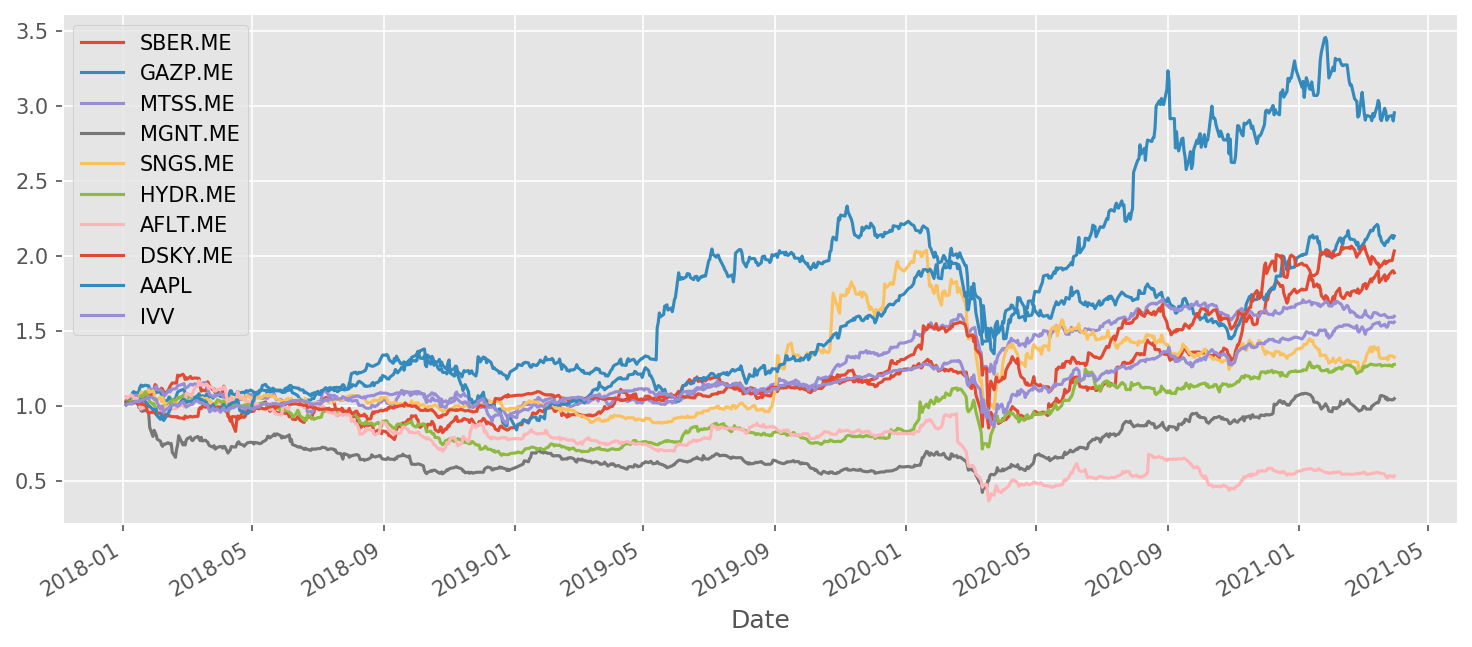

In [7]:
portfolio1.graphics()

In [8]:
portfolio1.resample_to_months()
portfolio1.new_data.head(4)

,SBER.ME,GAZP.ME,MTSS.ME,MGNT.ME,SNGS.ME,HYDR.ME,AFLT.ME,DSKY.ME,AAPL,IVV
Date,,,,,,,,,,
2018-01-31,176.207153,116.088120,222.070801,4187.981445,26.922180,0.625404,120.766647,66.784569,40.219990,266.416565
2018-02-28,181.470032,115.926170,221.064667,3757.396973,26.898762,0.673677,128.150345,65.340576,42.962379,256.281250
2018-03-31,168.925705,115.254066,211.398468,3677.251709,26.575584,0.663678,140.969910,69.636444,40.468391,249.931442
2018-04-30,151.218384,118.169220,213.015472,3851.685303,27.577906,0.642213,130.460587,67.434357,39.860565,250.816803


In [9]:
portfolio1.get_month_return()

SBER.ME    0.017025
GAZP.ME    0.021329
MTSS.ME    0.010338
MGNT.ME    0.009673
SNGS.ME    0.009748
HYDR.ME    0.009006
AFLT.ME   -0.008936
DSKY.ME    0.022915
AAPL       0.034300
IVV        0.011985
dtype: float64

In [10]:
portfolio1.get_month_COV()

,SBER.ME,GAZP.ME,MTSS.ME,MGNT.ME,SNGS.ME,HYDR.ME,AFLT.ME,DSKY.ME,AAPL,IVV
SBER.ME,0.007742,0.003621,0.002223,0.002937,0.002593,0.002721,0.005487,0.004310,0.002679,0.003000
GAZP.ME,0.003621,0.007453,0.001523,0.001071,0.003036,0.000592,0.004225,0.001905,0.001277,0.001716
MTSS.ME,0.002223,0.001523,0.002119,0.001550,0.001581,0.001655,0.002262,0.001176,0.002558,0.001493
MGNT.ME,0.002937,0.001071,0.001550,0.006899,0.000678,0.002883,0.002790,0.001849,0.002440,0.001802
SNGS.ME,0.002593,0.003036,0.001581,0.000678,0.006829,0.000291,0.003697,0.001473,0.002672,0.001987
HYDR.ME,0.002721,0.000592,0.001655,0.002883,0.000291,0.004411,0.002496,0.002341,0.002095,0.001367
AFLT.ME,0.005487,0.004225,0.002262,0.002790,0.003697,0.002496,0.012188,0.004685,0.004531,0.003951
DSKY.ME,0.004310,0.001905,0.001176,0.001849,0.001473,0.002341,0.004685,0.005999,0.001874,0.001629
AAPL,0.002679,0.001277,0.002558,0.002440,0.002672,0.002095,0.004531,0.001874,0.009614,0.003541
IVV,0.003000,0.001716,0.001493,0.001802,0.001987,0.001367,0.003951,0.001629,0.003541,0.002812


In [11]:
portfolio1.get_month_risk(portfolio1.w)

0.002825900945987014

## Portfolio optimization

In [234]:
rf = 0.0037
names = ['SBER.ME','GAZP.ME', 'MTSS.ME', 'MGNT.ME', 'SNGS.ME', 'HYDR.ME', 'AFLT.ME', 'DSKY.ME', 'AAPL', 'IVV']
# names = ['AAPL', 'AMZN', 'IBM', 'SBER.ME']
dates = ('2018-01-01', '2021-02-01')
n = len(names)

portfolio_opt = OptimizationP(names, dates)
portfolio_opt.get_help()

maxReturn - maximize return of the portfolio
minRisk - minimize risk of the portfolio 
maxSharpe - maximize a Sharpe ratio
maxSortino - maximize a Sortino ratio 
minGenFun - minimize generalized function


In [235]:
portfolio_opt.get_ts_csv()
# portfolio_opt.get_ts()

In [236]:
portfolio_opt.resample_to_months()

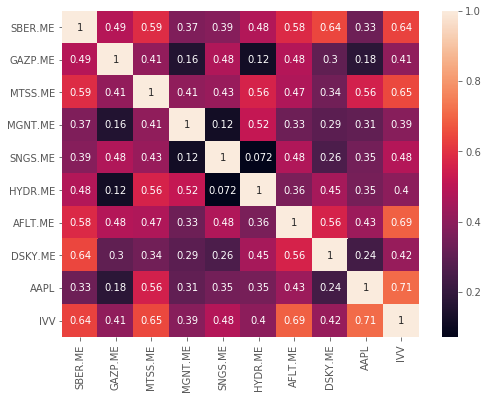

In [237]:
portfolio_opt.corr_matrix()

In [238]:
p_return = portfolio_opt.get_month_return()
p_cov = portfolio_opt.get_month_COV()

## Equally allocation

In [239]:
portfolio_opt.w

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [240]:
print(f'Return: {round(portfolio_opt.get_returnP()*100, 3)} %')
print(f'Risk: {round(portfolio_opt.get_riskP()*100, 3)} %')

Return: 1.033 %
Risk: 0.297 %


## Maximize return

In [241]:
max_return = portfolio_opt.optimizeP('maxReturn', (0, 1), 0, rf)
max_return

     fun: -0.032962264957272086
     jac: array([-0.01064973, -0.01694936, -0.0109732 , -0.00443516, -0.00610109,
       -0.00615026,  0.01517284, -0.02107143, -0.03296226, -0.00914378])
 message: 'Optimization terminated successfully.'
    nfev: 168
     nit: 14
    njev: 14
  status: 0
 success: True
       x: array([0.00000000e+00, 7.41852379e-17, 5.66913050e-17, 1.28276694e-16,
       0.00000000e+00, 0.00000000e+00, 8.50474479e-17, 0.00000000e+00,
       1.00000000e+00, 3.30581100e-17])

In [242]:
max_return_ret = round(np.dot(p_return, max_return.x), 3)*100
max_return_risk = round(np.dot(max_return.x, np.dot(p_cov, max_return.x)), 3)*100

print(f'Return: {round(max_return_ret, 3)} %')
print(f'Risk: {round(max_return_risk, 3)} %')

Return: 3.3 %
Risk: 1.0 %


## Maximize Sharpe ratio

In [243]:
max_sharpe = portfolio_opt.optimizeP('maxSharpe', (0, 1), 0.01, rf)
max_sharpe

     fun: -6.157416022944237
     jac: array([11.29606324,  4.68234122,  4.67876995,  6.87836528,  7.44708103,
        6.58938843, 26.01048303,  4.68366146,  4.68397659,  6.79730189])
 message: 'Optimization terminated successfully.'
    nfev: 148
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([2.38046135e-13, 1.22602524e-01, 3.90682106e-01, 0.00000000e+00,
       6.87707621e-16, 0.00000000e+00, 8.33758510e-13, 2.75679898e-01,
       2.11035472e-01, 0.00000000e+00])

In [244]:

max_sharpe_ret = round(np.dot(p_return, max_sharpe.x)*100, 3)
max_sharpe_risk = round(np.dot(np.dot(max_sharpe.x, p_cov), max_sharpe.x)*100, 3)
max_sharpe_ratio = -max_sharpe.fun

print(f'Return: {round(portfolio_opt.get_returnP()*100, 3)} %')
print(f'Risk: {round(portfolio_opt.get_riskP()*100, 3)} %')
print(f'Sharpe ratio: {round(max_sharpe_ratio, 3)}')

Return: 1.913 %
Risk: 0.251 %
Sharpe ratio: 6.157


## Maximize Sortino ratio

In [245]:
max_sortino = portfolio_opt.optimizeP('maxSortino', (0, 1), 0, rf)
max_sortino

     fun: -821.5485690134126
     jac: array([-298.99488068, -475.85923767, -308.07652283, -124.51879883,
       -171.29023743, -172.67086029,  425.98301697, -591.58795929,
       -925.42738342, -256.71497345])
 message: 'Optimization terminated successfully.'
    nfev: 25
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([0.00000000e+00, 4.97943899e-10, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.13332485e-08,
       1.00000000e+00, 0.00000000e+00])

In [246]:
max_sort_ret = round(np.dot(p_return, max_sortino.x)*100, 3)
max_sort_risk = round(np.dot(np.dot(max_sortino.x, p_cov), max_sortino.x)*100, 3)

print(f'Return: {round(max_sort_ret, 3)} %')
print(f'Risk: {round(max_sort_risk, 3)} %')

Return: 3.296 %
Risk: 0.95 %


## Minimize risk

In [247]:
min_risk = portfolio_opt.optimizeP('minRisk', (0, 1), 0, rf)
min_risk

     fun: 0.001872596433891858
     jac: array([0.00556894, 0.00354635, 0.00354921, 0.00367303, 0.00379473,
       0.00411315, 0.00681529, 0.00369617, 0.00528905, 0.00380729])
 message: 'Optimization terminated successfully.'
    nfev: 180
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([8.77708367e-18, 3.02253610e-02, 4.09235619e-01, 1.10467957e-02,
       8.38538020e-02, 1.97811369e-01, 0.00000000e+00, 5.90498606e-02,
       0.00000000e+00, 2.08777193e-01])

In [248]:
min_risk_ret = round(np.dot(p_return, min_risk.x)*100, 3)
min_risk_risk = round(np.dot(np.dot(min_risk.x, p_cov), min_risk.x)*100, 3)

print(f'Return: {round(min_risk_ret, 3)} %')
print(f'Risk: {min_risk_risk} %')

Return: 0.993 %
Risk: 0.187 %


## Minimize generalized function

In [249]:
portfolio_opt.optimizeP('minGenFun', (0.05, 0.15), 0, rf, 0.05)

     fun: 0.0006733396320389117
     jac: array([0.00292967, 0.00168947, 0.00124664, 0.00215042, 0.00210903,
       0.00176444, 0.00543373, 0.00148312, 0.00172888, 0.00184639])
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([0.05      , 0.11418843, 0.13790986, 0.09255938, 0.09392554,
       0.11327103, 0.05      , 0.1236084 , 0.11709431, 0.10744305])

In [26]:
print(f'Return: {round(portfolio_opt.get_returnP()*100, 3)} %')
print(f'Risk: {round(portfolio_opt.get_riskP()*100, 3)} %')

Return: 1.235 %
Risk: 0.258 %


## Minimize generalized function with free risk asset

In [403]:
genfunfree = portfolio_opt.optimizeP('minGenFunFree', (0.05, 0.15), 0, rf, 1)
genfunfree

     fun: -0.015977434824795713
     jac: array([-0.01061654, -0.01772366, -0.01023437, -0.00561359, -0.00700355,
       -0.0063462 ,  0.01296572, -0.0212833 , -0.0347681 , -0.00828998,
       -0.0037    ])
 message: 'Optimization terminated successfully.'
    nfev: 156
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([0.13395626, 0.15      , 0.11604374, 0.05      , 0.05      ,
       0.05      , 0.05      , 0.15      , 0.15      , 0.05      ,
       0.05      ])

In [404]:
print(f'Return: {round(portfolio_opt.get_returnP_free(rf)*100, 3)} %')
print(f'Risk: {round(portfolio_opt.get_riskP_free()*100, 3)} %')

Return: 1.738 %
Risk: 0.28 %


## Multi-criteria optimization

In [19]:
res1 = portfolio_opt.multi_criteria_opt((0, 1), 0.01, rf, 1)
res1

     fun: 0.9486356012847665
     jac: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
 message: 'Optimization terminated successfully.'
    nfev: 158
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([0.00000000e+00, 1.36997515e-01, 0.00000000e+00, 1.31566945e-16,
       2.83838702e-17, 3.44874988e-17, 0.00000000e+00, 3.61261585e-01,
       5.01740900e-01, 0.00000000e+00, 9.48635601e-01])

In [20]:
print(f'Return: {round(portfolio_opt.get_returnP()*100, 3)} %')
print(f'Risk: {round(portfolio_opt.get_riskP()*100, 3)} %')

Return: 2.647 %
Risk: 0.431 %


## Efficient frontier

In [250]:
h0, h1, a0, a1, b0 = portfolio_opt.optimal_t()
a0 = a0*100
a1 = a1*100
b0 = b0*100
b0

0.11870417055743322

In [251]:
# optimal t
t0 = (max_return_ret - a0)/a1
t0

0.054592538364343766

In [252]:
eff_frontier = portfolio_opt.efficient_frontier((0, 1), 0.01)
not_eff_reg = portfolio_opt.not_efficient_region((0, 1), 0.01)

In [278]:
coef = np.polyfit(np.append(eff_frontier[1],not_eff_reg[1]), np.append(eff_frontier[0],not_eff_reg[0]), 2)

def ef_fr(coef):
    return coef[2] + coef[1]*x + coef[0]*x**2

In [253]:
num_portf = 1000
p_r = []
p_std = []
p_w = []
sharpe_ratio = []

for i in range(num_portf):
    w = np.random.uniform(0, 1, n)
    w = w/np.sum(w)
#     w = np.random.dirichlet(np.ones(n)*100,size=1)[0]
    p_w.append(w)
    
    returns = np.dot(w, p_return)
    p_r.append(round(100*returns, 3))
    
    std = np.dot(np.dot(w, p_cov), w)
    p_std.append(round(100*std, 3))
    
    sharpe_ratio.append((returns - rf)/std)

In [254]:
array = {'Returns':p_r, 'Risks':p_std}

for i, stock in enumerate(names):
    array[stock] = [w[i] for w in p_w]
    
portfolios = pd.DataFrame(array)    
portfolios.head(5)

,Returns,Risks,SBER.ME,GAZP.ME,MTSS.ME,MGNT.ME,SNGS.ME,HYDR.ME,AFLT.ME,DSKY.ME,AAPL,IVV
0,1.069,0.315,0.092293,0.096363,0.095864,0.084406,0.089924,0.097051,0.122039,0.106668,0.131877,0.083515
1,0.930,0.356,0.171549,0.044502,0.059213,0.153966,0.006162,0.090986,0.141654,0.121326,0.103221,0.107420
2,0.921,0.359,0.174630,0.135215,0.064613,0.100681,0.030769,0.120524,0.141275,0.201765,0.024737,0.005791
3,1.345,0.263,0.078225,0.150218,0.051918,0.059881,0.129759,0.085106,0.015014,0.161499,0.096275,0.172105
4,1.210,0.322,0.083193,0.011885,0.153149,0.101385,0.068611,0.047596,0.118459,0.167659,0.175129,0.072934


In [255]:
((portfolios['Returns']-rf)/portfolios['Risks']).max()

6.281923076923077

In [256]:
sharpe = portfolios.iloc[((portfolios['Returns']-rf)/portfolios['Risks']).argmax()]
sharpe

Returns    1.637000
Risks      0.260000
SBER.ME    0.013460
GAZP.ME    0.120794
MTSS.ME    0.111924
MGNT.ME    0.087362
SNGS.ME    0.042121
HYDR.ME    0.079096
AFLT.ME    0.000241
DSKY.ME    0.157716
AAPL       0.208410
IVV        0.178877
Name: 738, dtype: float64

In [265]:
def CML(x, r, var):
    return rf + x*(r-rf)/var

def f(x):
    return np.sqrt(a1*(x - b0)) + a0

x = np.linspace(min_risk_risk/2, (max_return_risk)/2+0.2, 50)

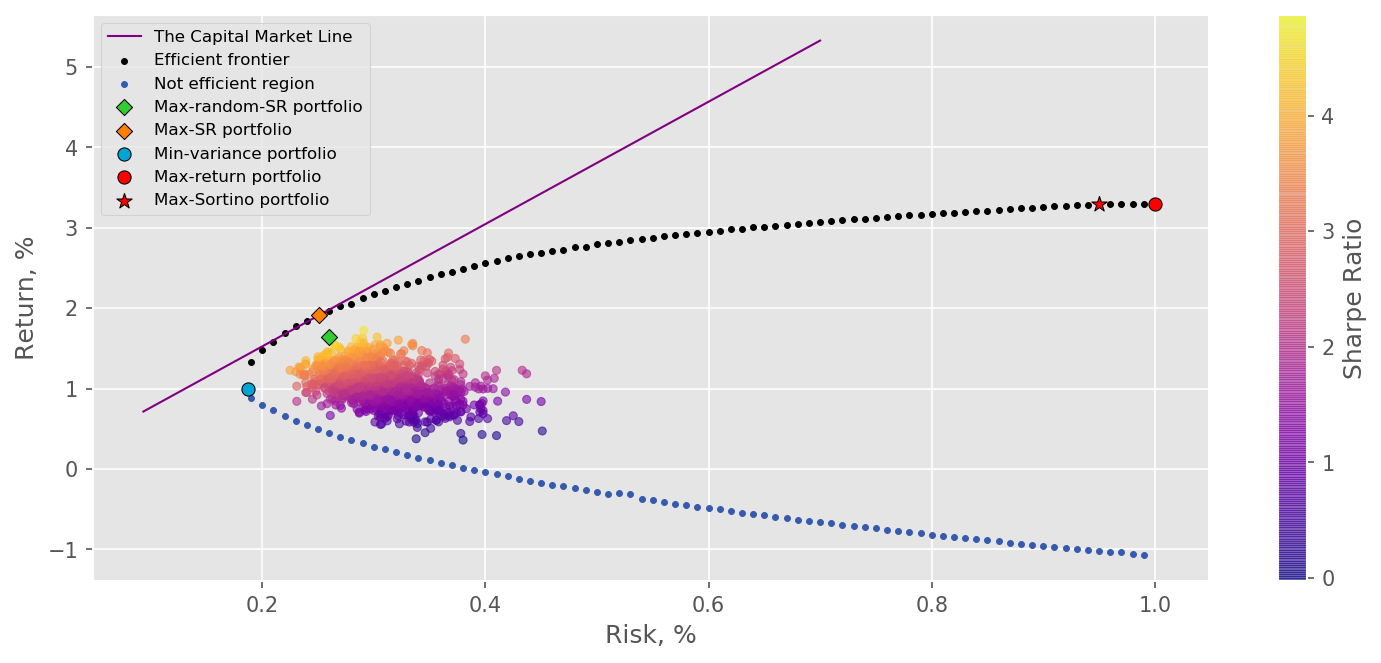

In [281]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=150)

plt.scatter(eff_frontier[0], eff_frontier[1], c='black', zorder=2, s=8, label='Efficient frontier')
plt.scatter(not_eff_reg[0], not_eff_reg[1], c='#365aad', zorder=2, s=8, label='Not efficient region')

plt.scatter(portfolios['Risks'], portfolios['Returns'], s=15, alpha=0.6, c=sharpe_ratio, cmap='plasma')
plt.colorbar(label = 'Sharpe Ratio')

plt.plot(x, CML(x, max_sharpe_ret, max_sharpe_risk), linewidth=1, c='purple', \
           label='The Capital Market Line', zorder=2) #the CML

plt.scatter(sharpe['Risks'], sharpe['Returns'], s=30, c='#32CD32', marker='D', \
            edgecolor='black', label='Max-random-SR portfolio', zorder=3)#Random best sharpe ratio (0, 1)

plt.scatter(max_sharpe_risk, max_sharpe_ret, s=30, c='#ff8000', edgecolor='black', \
           label='Max-SR portfolio', marker='D', zorder=3) #sharpe ratio (0, 1)

plt.scatter(min_risk_risk, min_risk_ret, s=40, c='#02a4d3', edgecolor='black', \
           label='Min-variance portfolio', zorder=3) #min risk (0, 1)

plt.scatter(max_return_risk, max_return_ret, s=40, c='r', edgecolor='black', \
           label='Max-return portfolio', zorder=3) #max return (0, 1)

plt.scatter(max_sort_risk, max_sort_ret, s=60, c='r', edgecolor='black', \
           label='Max-Sortino portfolio', marker='*', zorder=3) #max return (0, 1)

plt.xlabel('Risk, %')
plt.ylabel('Return, %')
# plt.xlim(min_risk_risk-0.02, max_return_risk+0.02)
# plt.ylim(-1, 10)
plt.legend(loc=2, prop={'size': 8})
plt.show()

## Indicators

In [33]:
#download market portfolio
market_portfolio = yf.download('SPY', dates[0], dates[1])['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [34]:
mp_pct_change = market_portfolio.resample('M').last().pct_change(1).apply(lambda x: np.log(1+x))
mp_mean = mp_pct_change.mean()
mp_var = mp_pct_change.var()
print(f'Market portfolio mean: {round(mp_mean*100, 3)} %\nMarket portfolio variance: {round(mp_var*100, 3)} %')

Market portfolio mean: 0.912 %
Market portfolio variance: 0.288 %


In [35]:
all_ind_ret = np.array([max_return_ret, max_sharpe_ret, max_sort_ret, min_risk_ret])
all_ind_risk = np.array([max_return_risk, max_sharpe_risk, max_sort_risk, min_risk_risk])
all_w = np.array([max_return.x, max_sharpe.x, max_sortino.x, min_risk.x])

In [36]:
pct_change = portfolio_opt.get_pct_change()
month_return = portfolio_opt.get_month_return()
beta_ind = []
n = len(names)

for i in range(n):
    beta_ind.append(((mp_pct_change.values[1:] * pct_change.iloc[1:, i].values).mean()-mp_mean*month_return[i])/mp_var)
    
all_beta = []

for i in range(len(all_w)):
    all_beta.append(np.dot(np.array(beta_ind), all_w[i]))

In [37]:
indicators = np.array([np.array(all_ind_ret/all_ind_risk), all_beta, (all_ind_ret-rf)/all_beta])
columns = ['Max return', 'Max Sharpe ratio', 'Max Sortino ratio', 'Min risk']
index = ['Return/Risk', 'Beta', 'Treynor ratio']

indicators_df = pd.DataFrame(indicators, columns=columns, index=index)
indicators_df

,Max return,Max Sharpe ratio,Max Sortino ratio,Min risk
Return/Risk,3.300000,7.621514,3.469474,5.310160
Beta,1.263192,0.714494,1.263192,0.635805
Treynor ratio,2.609501,2.672240,2.606335,1.555981


# Modeling

In [192]:
#download currency information
curr = yf.download('RUB=X', dates[1], datetime.date.today())['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [366]:
budget = 1000000
rf = 0.0037
names = ['SBER.ME','GAZP.ME', 'MTSS.ME', 'MGNT.ME', 'SNGS.ME', 'HYDR.ME', 'AFLT.ME', 'DSKY.ME', 'AAPL', 'IVV']
# names = ['SBER.ME', 'AAPL', 'AMZN', 'IBM']

dates = ('2018-01-01', '2021-02-01')
m = 8 #stocks in currency 1
# m = 1
t = 0.1

In [361]:
class Model:
    def __init__(self, type_opt, names, dates, m, rf, t, curr, budget, rb=False):
        self.type_opt = type_opt
        self.portfolio = OptimizationP(names, dates)
        self.rf = rf
        self.t = t
        self.costs = []
        self.res = []
        self.m = m
        self.curr = curr
        self.budget = budget
        self.forecast_data = []
        self.names = names
#         self.portfolio.get_ts()
        self.portfolio.get_ts_csv()
        self.portfolio.resample_to_months()
        self.income = []
        self.rb = rb
        self.cov_matrix = 0
        self.r = 0
        self.risk = 0.01
        
    def opt(self):
        if self.type_opt == 'multi-criteria':
            self.portfolio.multi_criteria_opt((0, 1), 0.01, self.rf, self.t)
        else:
            self.portfolio.optimizeP(self.type_opt, (0, 1), 0.01, self.rf)
            
        self.cov_matrix = self.portfolio.get_month_COV()
        self.risk = np.dot(self.portfolio.w[:self.portfolio.n], \
                           np.dot(self.cov_matrix, self.portfolio.w[:self.portfolio.n]))
        self.r = np.dot(self.portfolio.w[:self.portfolio.n], self.portfolio.get_month_return())
        
    def buy(self): #get quantity of assets at moment t0
        self.opt()
        self.costs = []
        self.res = []
        self.costs = np.array(self.portfolio.data.iloc[-1])

        q = np.dot(self.portfolio.w, self.budget)

        for i in range(self.m):
            self.res.append(q[i] / self.costs[i])

        for i in range(self.m, self.portfolio.n):
            self.res.append(q[i] / (self.curr[-1]*self.costs[i]))

        return self.res
    
    
    def quant(self):
        temp = self.buy()
        return f'Quantity {self.type_opt}: {[round(i) for i in temp]}'
    
    def forecast(self):
        self.forecast_data = []
        for name in self.names:
            model = ARIMA(self.portfolio.new_data[name], order=(1,2,1), freq='M')
            model_fit = model.fit()
            forecast = model_fit.forecast(5)
            self.forecast_data.append(np.array(forecast))

        self.forecast_data = np.array(self.forecast_data)
        return self.forecast_data
    
    def portfolio_return(self):
        self.forecast()
        if self.rb:
            total_income = 0
            self.rb_data = self.portfolio.data
            for j in range(len(self.forecast_data[0])):
                self.portfolio.data.loc[f'pr{j}'] = self.forecast_data.T[j]
                self.income = []
                s = self.buy()
                for i in range(self.m):
                    self.income.append(self.forecast_data[i, j]*s[i] +\
                                   s[i]*self.costs[i]*np.random.normal(loc=self.r, scale=np.sqrt(self.risk)))

                for i in range(self.m, self.portfolio.n):
                    self.income.append(self.forecast_data[i, j]*self.curr[-1]*s[i] +\
                                       s[i]*self.costs[i]*np.random.normal(loc=self.r, scale=np.sqrt(self.risk)))
                total_income += sum(self.income) - self.budget
                print(total_income)
#                 total_income.append(sum(self.income)-self.budget)
#                 print(total_income)
            return total_income
        
        elif not self.rb:    
            self.income = []
            s = self.buy()

            for i in range(self.m):
                self.income.append(self.forecast_data[i, -1]*s[i] +\
                                   s[i]*self.costs[i]*np.random.normal(loc=self.r, scale=np.sqrt(self.risk)))

            for i in range(self.m, self.portfolio.n):
                self.income.append(self.forecast_data[i, -1]*self.curr[-1]*s[i] +\
                                   s[i]*self.costs[i]*np.random.normal(loc=self.r, scale=np.sqrt(self.risk)))

            return sum(self.income) - self.budget   
        
        else:
            print('Specify True or False rebalance!')

In [367]:
names_opt = ('maxReturn', 'minRisk', 'maxSharpe', 'maxSortino', 'minGenFun', 'minGenFunFree', 'multi-criteria')
total_return = []
quantities = []
rb = False

for name in names_opt:
    model = Model(name, names, dates, m, rf, t, curr, budget, rb)
    total_return.append(model.portfolio_return())
    quantities.append(model.quant())

In [368]:
for i, name in enumerate(names_opt):
    print(f'{name}: {round(total_return[i], 3)}')

maxReturn: 100137.913
minRisk: 83756.265
maxSharpe: 79944.974
maxSortino: 97395.751
minGenFun: 93882.292
minGenFunFree: 119665.596
multi-criteria: 120042.347


In [340]:
quantities

['Quantity maxReturn: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 91.0, 0.0]',
 'Quantity minRisk: [0.0, 138.0, 1214.0, 2.0, 2673.0, 243782.0, 0.0, 382.0, 0.0, 7.0]',
 'Quantity maxSharpe: [0.0, 547.0, 1128.0, 0.0, 0.0, 0.0, 0.0, 1736.0, 19.0, 0.0]',
 'Quantity maxSortino: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 91.0, 0.0]',
 'Quantity minGenFun: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 958.0, 77.0, 0.0]',
 'Quantity minGenFunFree: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 976.0, 79.0, 0.0]',
 'Quantity multi-criteria: [0.0, 670.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2383.0, 47.0, 0.0]']